## Table of Contents

1. [Problem Statement](#problem)<br>
    1.1. [Solution Abstract](#abstract)<br>
 
2. [Data Exploration](#explore)<br>
    2.1 [Import the packages](#import)<br> 
    2.2 [Function Definition](#funcdef)<br> 
    2.3 [Input Image](#inpimg)<br> 
    2.4 [Image details](#imgdetails)<br>
    
3. [Data/Image Transformations](#trans)<br>
    3.1 [Gray scale transform](#grayimg)<br>
    3.2 [Image Resize](#imgresize)<br>
    3.3 [Gaussian blur transform](#gaussian)<br>
    3.4 [Hough transform](#hough)<br>
    3.5 [Image Segmentation (OTSU)](#otsu)<br>
    3.6 [Image dilation](#dilation)<br>
    
4. [Volume of the object](#volume)<br>

5. [Testing/Results](#results)<br>

6. [Conclusion](#conclusion)<br>

7. [Next steps](#nextsteps)<br>

8. [References](#references)<br>

9. [Azure Resources](#azure)<br>
<br>

### 1.0 Problem Statement <a id="problem"></a>

“Volumetric Analysis using Computer Vision”
<br>
 
<br>
The problem is to determine volume of an object (for example a tennis ball, golf ball etc.) from different perspectives of the same object captured from a mobile camera.<br>

Each image captured should have a ruler ( our usual calibrated ruler, of 15cm) which is placed in horizontal or vertical position in the image so that the ruler and its calibration are clearly visible. <br>

#### 1.1 Solution Abstract <a id="abstract"></a>

* Finding volume of an object using computer vision is an interesting challenge. The object can be measured physically using a ruler, but using computer vision to calibrate it is a bit challenging. <br>
* To address this challenge, the following approach is proposed. The demonstration that is shown here has an object and a ruler in the same image. This enables easy calibration of the radius or width of the object. The standard 6 inch/15 cm ruler is used for calibration. The ruler width (in pixels) are detected and used to find the volume of object. <br>
* The proposed method uses traditional computer vision techniques to find the object and its contours. The method uses preprocessing techniques, hough transform and contour detection. <br>
* The implementation is done on Azure compute using the free tier subscription. The notebook is used in Azure Machine Learning Services environment. <br>
* This approach is faster approach that works as Proof of Concept (PoC). In case of increase in the object category or increase in background complexity (or noises), this method can be supplemented further by using deep learning based object detection techniques. In this case, more data and a shallow neural network can be used. <br>
* This technique has been tested on various spherical objects and their results are provided in the final section. <br>
* The results are verified by manually measuring the radius of the object and found to be approximate. <br>
* Images are uploaded in github: https://github.com/gomathyshankar/volumetric-analysis.git <br>

### 2.0 Data Exploration <a id="explore"></a>

The data that I have captured contains: <br>
* A Spherical object - from different perspectives <br>
* A standard scale/ruler for calibration <br>

#### 2.1 Import the packages <a id="import"></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
cv2.__version__

'4.5.4-dev'

#### 2.2 Function Definition <a id="funcdef"></a>

In [3]:
def get_shapes(c):
    """
    This function gets the contour coordinates and outputs the shape using 
    approximations of polygonal curves to the specified precision. 
    """    
    # initialize the shape name and approximate the contour
    shape = "not identified"
    # Calculate the perimeter of the contour
    peri = cv2.arcLength(c, True)
    # Function to approcimate the contours to a shape
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    # Triangle shape will have 3 vertices
    if len(approx) == 3:
        shape = "triangle"
    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(approx) == 4:
        # compute the bounding box of the contour and use the
        # bounding box to compute the aspect ratio
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
    # if the shape is a pentagon, it will have 5 vertices
    elif len(approx) == 5:
        shape = "pentagon"
    # otherwise, assume the shape is a circle
    else:
        shape = "circle"
    # return the name of the shape and the approx coordinates
    return shape, approx

#### 2.3 Input Image <a id="inpimg"></a>

In [4]:
!git clone https://github.com/gomathyshankar/volumetric-analysis.git

fatal: destination path 'volumetric-analysis' already exists and is not an empty directory.


In [5]:
img_file = r"volumetric-analysis/IMG-0656.jpg"

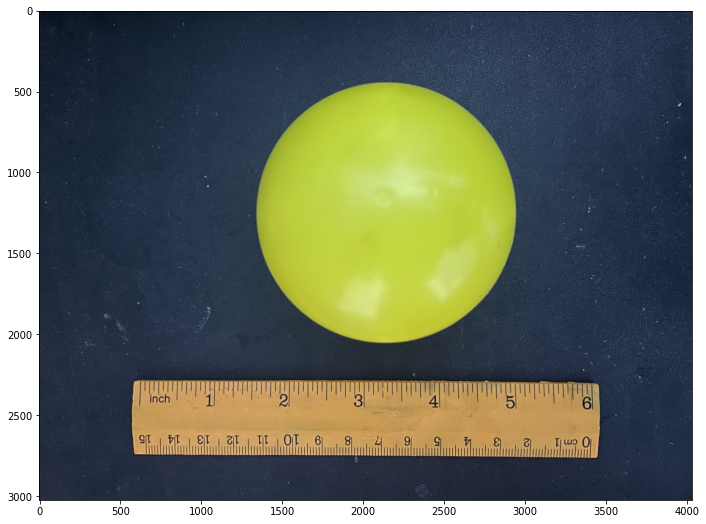

In [6]:
img_org = cv2.imread(img_file)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.show()

#### 2.4 Image details <a id="imgdetails"></a>

The next step is to get some details of the image. The resolution of the images are (3024x4032). The images are taken from my mobile phone and the details of the same can be found using PIL library. 

In [7]:
img_org.shape

(3024, 4032, 3)

In [8]:
from PIL import Image
from PIL.ExifTags import TAGS
  
# open the image
image = Image.open(img_file)
  
# extracting the exif metadata
exifdata = image.getexif()
for tagid in exifdata:
    # getting the tag name instead of tag id
    tagname = TAGS.get(tagid, tagid)
    # passing the tagid to get its respective value
    value = exifdata.get(tagid)
    # printing the final result
    print(f"{tagname:25}: {value}")

TileWidth                : 512
TileLength               : 512
ResolutionUnit           : 2
ExifOffset               : 238
Make                     : Apple
Model                    : iPhone 12
Software                 : 14.8
Orientation              : 1
DateTime                 : 2021:10:29 21:52:38
YCbCrPositioning         : 1
XResolution              : 72.0
YResolution              : 72.0
HostComputer             : iPhone 12


### 3.0 Data/Image Transformations <a id="trans"></a>

The next steps are to transform the image so that the segmentations results are accurate. The image segmentation algorithms often need the image to be noise-free, gray scale transformed images. Hence the first step is to perform the gray scale transform operation on the color image.

#### 3.1 Gray scale transform <a id="grayimg"></a>

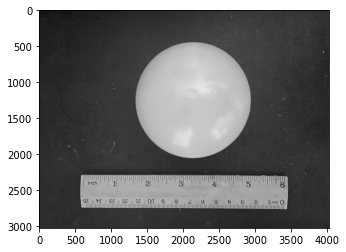

In [9]:
gray_img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap="gray")
plt.show()

#### 3.2 Image resize <a id="imgresize"></a>

The images are of resolution (3Kx4K). Usually the processing of image on bigger images is time consuming and the recommendations are to lower the dimensions of the images by a certain percentage. 

In [10]:
#percent by which the image is resized
scale_percent = 20

#calculate the 50 percent of original dimensions
width = int(gray_img.shape[1] * scale_percent / 100)
height = int(gray_img.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

res_color = cv2.resize(img_org, dsize)
res_color_copy = res_color.copy()
res_img = cv2.resize(gray_img, dsize)


#### 3.3 Gaussian blur transform <a id="gaussian"></a>

The background contains some spurious noise because of various factors pertaining to the illumination and the image quality. Gaussian blur reduces these type of noise by convolving a smoothening kernel over the image. 
Here (7,7) is the size of the kernel. 

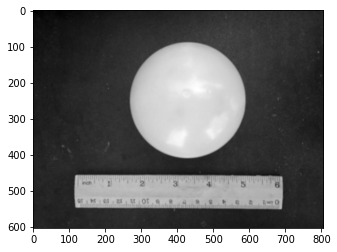

In [11]:
blurred = cv2.GaussianBlur(res_img, (7, 7), 0)

plt.imshow(blurred, cmap="gray")
plt.show()

#### 3.4 Hough transform <a id="hough"></a>

* The object in the picture is a spherical object. Hence we use Hough transform to localize the spherical object in the image. <br>
* This is similar to the object detection algorithms but a faster version of it. We know that the prior is a circle shape and hence we use this cue to identify the spherical object from the image. <br>
* The minimum and maximum radius is defined in the Hough circles function. <br>

In [12]:
circles_list = []
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 100)

In [13]:
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        circles_list.append([x,y])
        cv2.circle(res_color_copy, (x, y), r, (0, 0, 255), 4)
        cv2.rectangle(res_color_copy, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)


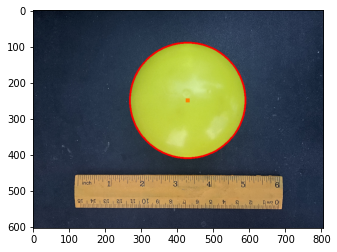

In [14]:
plt.imshow(cv2.cvtColor(res_color_copy, cv2.COLOR_BGR2RGB))
plt.show()

#### 3.5 Image Segmentation (OTSU) <a id="otsu"></a>

* After localizing with the object shape, the next important step is to calibrate the ruler. This can be done by identifying the width of the ruler and associate the width of the pixels to the scale in the ruler. <br>
* The standard ruler used here has 6 inches in its width. The ruler will have 4 coordinates - x,y,width and height. <br>
* The first step to find the width of the ruler is to start with image segmentation. There are various thresholding based segmentation approaches. One of the important algorithm is OTSU Segmentation. <br>
* OTSU Segmentation will work better in this scenario since the images that we are working with will have sharp and deep valley between two histogram peaks.


In [15]:
T, threshInv = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

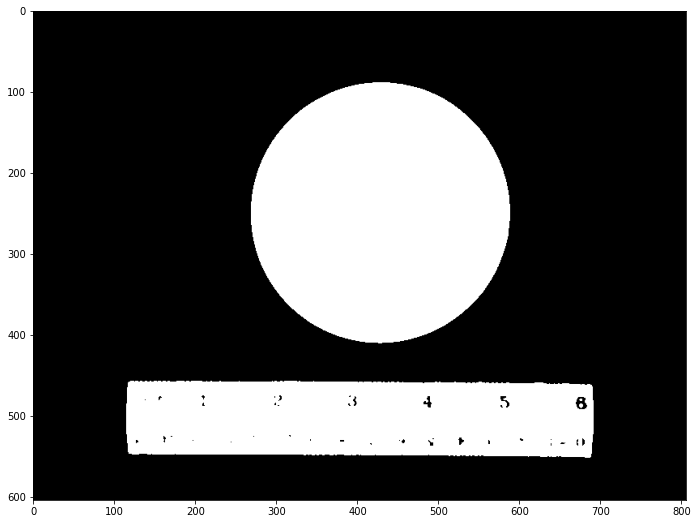

In [16]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)

plt.imshow(threshInv, cmap="gray")
plt.show()

* We can observe that the ruler segmentation results has numbers segmented as well. To arrive at the width of the bounding box, we need to further preprocess the image. Thus the image is applied with one of the type of morphological processing. <br>


#### 3.6 Image dilation <a id="dilation"></a>

* Dilation is one of the morphological processing. It is used to enlarge a particular mathematical element (in this case the white pixels). <br>

In [17]:
kernel = 255 * np.ones((7, 7), 'uint8')

dilated = cv2.dilate(threshInv.copy(), kernel, 3)

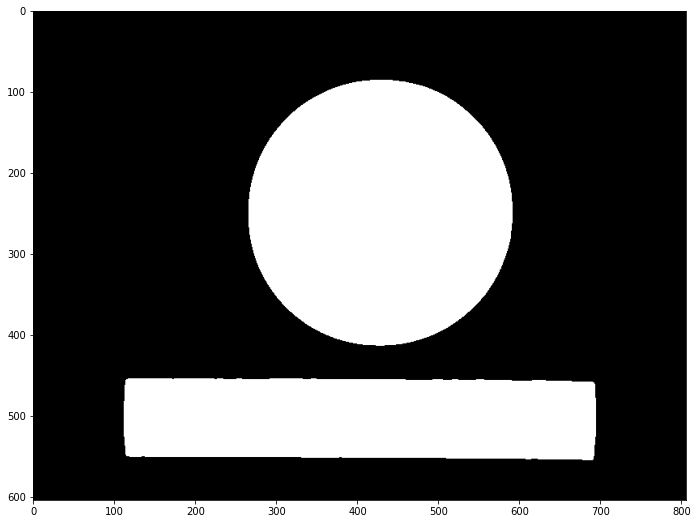

In [18]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)
plt.imshow(dilated, cmap="gray")
plt.show()

* Countours are used to find the object boundaries from binary images. In our the case the object boundaries are a sphere and a rectangle. <br>
* The mode used are Contour Retrieval tree based modes to find better contours. <br>

In [19]:
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)

In [20]:
#Find the contour area and the shapes
for c in contours:
    # contourArea finds the area from given contour coordinates
    contour_area = cv2.contourArea(c)
    # as per observation, the bigger contour areas have area > 10000
    if contour_area>10000:
        # the function gets the shapes and approximation of contours
        shape,approx = get_shapes(c)
        print(shape)
        print("Contour area: ", contour_area)
        # shape conditions are rectangle and circle
        if shape=='rectangle':
            (x, y, w, h) = cv2.boundingRect(approx)
            cv2.rectangle(res_color, (x,y), (x+w, y+h), (0,0,255), 4)
            if contour_area>50000:
                w_largest = w
                h_largest = h
        else:
            if shape=='circle':
                # find the moments, which enable us to calculate the center point of the object
                M = cv2.moments(c)
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                appr1 = approx
                # find the distance between center of the object and the circles detected earlier
                # this will reduce the false positives and will only take the closest to the contour center
                distances = euclidean_distances([[cX,cY]], circles_list)
                min_idx = np.argmin(distances)
                # draw the center point
                cv2.circle(res_color, (circles[min_idx][0], circles[min_idx][1]), circles[min_idx][2], (255, 255, 255), 4)
                cv2.putText(res_color, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                radius_pix = circles[min_idx][2]
                cv2.circle(res_color, (cX, cY), 7, (255, 255, 255), -1)
                
        cv2.drawContours(res_color, [c], -1, (0, 255, 0), 4)

circle
Contour area:  84137.0
rectangle
Contour area:  55621.5


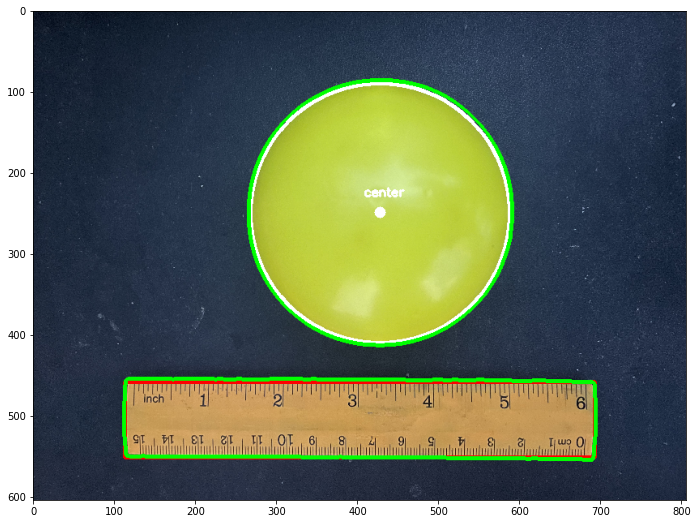

In [21]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)

plt.imshow(cv2.cvtColor(res_color, cv2.COLOR_BGR2RGB))
plt.show()

### 4.0 Volume of the object <a id="volume"></a>

* Volume of spherical object = 4/3 * pi * r^3

In [22]:
# find the volume (radius in terms of pixels)
# using the pixel width of the radius, calculate the radius in inches
# the standard ruler which is used here is 6 inches wide
radius_inch = radius_pix * 6 / w

# using the formula to calculate the volume of sphere
volume = 4/3 * np.pi * radius_inch**3
print("Radius is {} inches and volume is {}".format(radius_inch, volume))

Radius is 1.6551724137931034 inches and volume is 18.994082837661917


### 5.0 Testing Results <a id="results"></a>

Let's test the results further with other type of objects. I have taken different spherical objects of varying radius. 

In [23]:
def find_volume(img_file):
    img_org = cv2.imread(img_file)
    gray_img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
    #percent by which the image is resized
    scale_percent = 20

    #calculate the 50 percent of original dimensions
    width = int(gray_img.shape[1] * scale_percent / 100)
    height = int(gray_img.shape[0] * scale_percent / 100)

    # dsize
    dsize = (width, height)

    res_color = cv2.resize(img_org, dsize)
    res_color_copy = res_color.copy()
    res_img = cv2.resize(gray_img, dsize)

    # gaussian blur
    blurred = cv2.GaussianBlur(res_img, (7, 7), 0)

    # get the circle object coordinates using hough circles
    circles_list = []
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 100)

    # ensure at least some circles were found
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            circles_list.append([x,y])
            cv2.circle(res_color_copy, (x, y), r, (0, 0, 255), 4)
            cv2.rectangle(res_color_copy, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

    # image segmentation
    T, threshInv = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # dilation operation on the image
    kernel = 255 * np.ones((7, 7), 'uint8')
    dilated = cv2.dilate(threshInv.copy(), kernel, 3)

    # contour detection from the dilated image
    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    #Find the contour area and the shapes
    for c in contours:
        # contourArea finds the area from given contour coordinates
        contour_area = cv2.contourArea(c)
        # as per observation, the bigger contour areas have area > 10000
        if contour_area>10000:
            # the function gets the shapes and approximation of contours
            shape,approx = get_shapes(c)
            # shape conditions are rectangle and circle
            if shape=='rectangle':
                (x, y, w, h) = cv2.boundingRect(approx)
                cv2.rectangle(res_color, (x,y), (x+w, y+h), (0,0,255), 4)
                if contour_area>50000:
                    w_largest = w
                    h_largest = h
            else:
                if shape=='circle':
                    # find the moments, which enable us to calculate the center point of the object
                    M = cv2.moments(c)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    appr1 = approx
                    # find the distance between center of the object and the circles detected earlier
                    # this will reduce the false positives and will only take the closest to the contour center
                    distances = euclidean_distances([[cX,cY]], circles_list)
                    min_idx = np.argmin(distances)
                    # draw the center point
                    cv2.circle(res_color, (circles[min_idx][0], circles[min_idx][1]), circles[min_idx][2], (255, 255, 255), 4)
                    cv2.putText(res_color, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                    radius_pix = circles[min_idx][2]
                    cv2.circle(res_color, (cX, cY), 7, (255, 255, 255), -1)

            cv2.drawContours(res_color, [c], -1, (0, 255, 0), 4)

    return radius_pix, res_color



Radius is 1.6551724137931034 inches and volume is 18.994082837661917


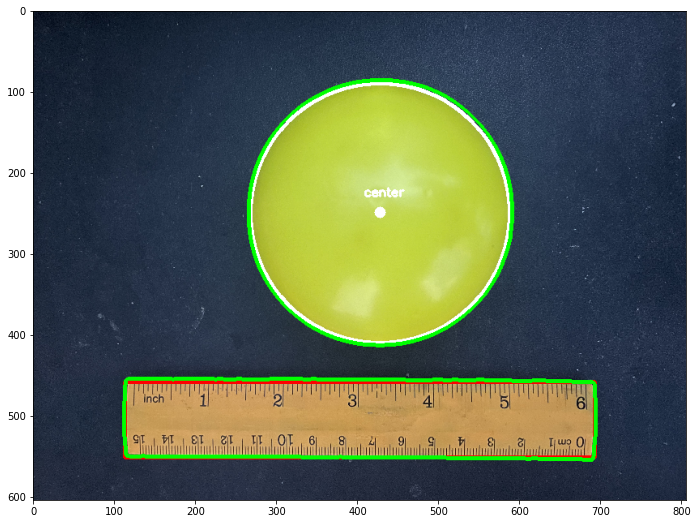

In [24]:
img_file = r"volumetric-analysis/IMG-0656.jpg"

# find the volume (radius in terms of pixels)
radius_pix, res_color = find_volume(img_file)

# using the pixel width of the radius, calculate the radius in inches
# the standard ruler which is used here is 6 inches wide
radius_inch = radius_pix * 6 / w

# using the formula to calculate the volume of sphere
volume = 4/3 * np.pi * radius_inch**3
print("Radius is {} inches and volume is {}".format(radius_inch, volume))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)

plt.imshow(cv2.cvtColor(res_color, cv2.COLOR_BGR2RGB))
plt.show()

Testing on other spherical objects.

Radius is 1.9965517241379311 inches and volume is 33.337291060222974


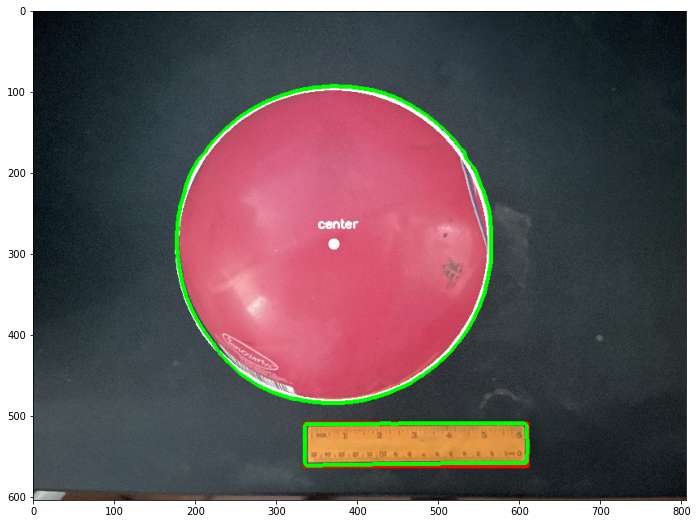

In [25]:
img_file = r"volumetric-analysis/IMG-0676.jpg"

radius_pix, res_color = find_volume(img_file)
radius_inch = radius_pix * 6 / w
volume = 4/3 * np.pi * radius_inch**3
print("Radius is {} inches and volume is {}".format(radius_inch, volume))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)

plt.imshow(cv2.cvtColor(res_color, cv2.COLOR_BGR2RGB))
plt.show()

Radius is 0.8689655172413793 inches and volume is 2.7485031431185467


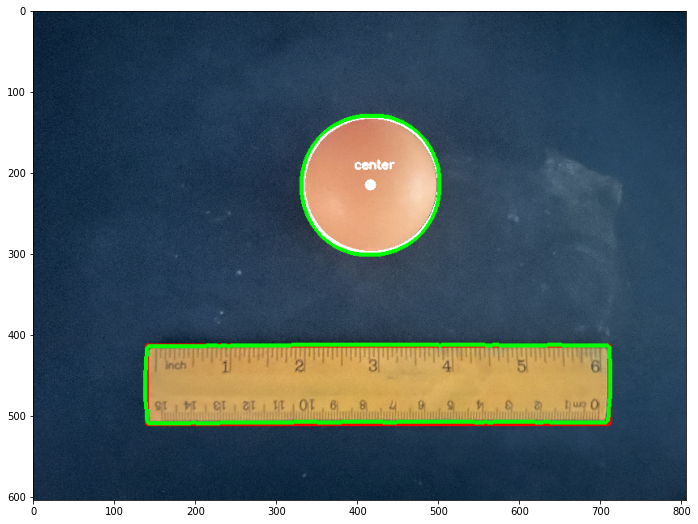

In [26]:
img_file = r"volumetric-analysis/IMG-0685.jpg"

radius_pix, res_color = find_volume(img_file)
radius_inch = radius_pix * 6 / w
volume = 4/3 * np.pi * radius_inch**3
print("Radius is {} inches and volume is {}".format(radius_inch, volume))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)

plt.imshow(cv2.cvtColor(res_color, cv2.COLOR_BGR2RGB))
plt.show()

### 6.0 Conclusion <a id="conclusion"></a>

* From the above steps, the steps are shown clearly to calculate the volume of object. The category considered here are spherical objects, however using the above steps, we can easily extend the approach to cube and cuboids as well. 

### 7.0 Next steps <a id="nextsteps"></a>

* This PoC (Proof of Concept) work demonstrates that we can find the volume for objects. 
* Other objects that can be tried as next steps: 
    * Cube and Cuboid
    * This work can be extended to find the volume of cube and cuboids. The image that I have captured for cuboid are as follows: 
        * https://github.com/gomathyshankar/volumetric-analysis/blob/main/IMG-0687.jpg
        * https://github.com/gomathyshankar/volumetric-analysis/blob/main/IMG-0688.jpg
* Other ways of calculating calibration from scale:
    * OCR can be used to identify the numbers in the scale and then to identify the pixels between them.
* Object detection using deep learning: 
    * The objects that are being considered in this PoC are simple objects. 
    * If the object categories increases, we can use the object detection algorithms to detect the objects. 
    * Image annotations can be done using open source tools such as labelimg, VIA, etc. The annotation format will depend on the algorithm being used. 


### 8.0 References <a id="references"></a>

* This approach has been inspired from https://ieeexplore.ieee.org/document/7578268 with further changes according to suit our application

### 9.0 Azure Resources <a id="azure"></a>

The resources used are: 
* Azure Virtual machine size - Standard_DS11_v2 (2 cores, 14 GB RAM, 28 GB disk) <br>
* Azure Machine Learning Service - Notebook